# Data Preprocessing and Visualization with PMF_toolkits

In this notebook, we've demonstrated the complete workflow for PMF analysis using PMF_toolkits:

1. **Data Preprocessing**:
   - Loading and examining raw data
   - Handling detection limits and missing values
   - Calculating uncertainties
   - Computing signal-to-noise ratios and correlations
   - Selecting appropriate species

2. **Data Analysis**:
   - Time series analysis
   - Regression and correlation analysis
   - Seasonal pattern analysis
   - Cluster analysis

3. **PMF Visualization**:
   - Factor profile visualization
   - Time series contribution plots
   - Seasonal contribution analysis
   - Pollution level analysis
   - Comprehensive factor visualization

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

from PMF_toolkits.preprocessing import PMFPreprocessor
from PMF_toolkits.core import PMF
from PMF_toolkits.utils import add_season, get_sourceColor, format_xaxis_timeseries, pretty_specie

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 1.1 Generate Sample Data

First, let's create a synthetic dataset that mimics real environmental data, including:
- Time series of measurements for multiple species
- Missing values
- Below detection limit values
- Seasonal patterns

In [2]:
# Create a date range for 2 years of daily data
dates = pd.date_range(start='2020-01-01', end='2021-12-31', freq='D')

# Initialize an empty DataFrame with the dates as index
data = pd.DataFrame(index=dates)

# Set random seed for reproducibility
np.random.seed(42)

# Generate data for PM10 with seasonal pattern (higher in winter)
winter_effect = 20 * (np.cos(np.pi * np.arange(len(dates))/182.5) + 1)
data['PM10'] = 25 + winter_effect + np.random.normal(0, 10, len(dates))
data['PM10'] = data['PM10'].clip(lower=0)  # No negative concentrations

# Generate correlated species
# SO4 - high in summer due to photochemistry
summer_effect = 5 * (-np.cos(np.pi * np.arange(len(dates))/182.5) + 1)
data['SO4'] = 3 + summer_effect + np.random.normal(0, 1, len(dates))
data['SO4'] = data['SO4'].clip(lower=0)

# NO3 - high in winter
data['NO3'] = 2 + 0.15 * winter_effect + np.random.normal(0, 1, len(dates))
data['NO3'] = data['NO3'].clip(lower=0)

# NH4 - correlated with SO4 and NO3
data['NH4'] = 0.3 * data['SO4'] + 0.2 * data['NO3'] + np.random.normal(0, 0.5, len(dates))
data['NH4'] = data['NH4'].clip(lower=0)

# OC - organic carbon, higher in winter (wood burning) and summer (biogenic)
data['OC'] = 5 + 0.1 * winter_effect + 0.05 * summer_effect + np.random.normal(0, 2, len(dates))
data['OC'] = data['OC'].clip(lower=0)

# EC - elemental carbon, correlated with OC
data['EC'] = 0.3 * data['OC'] + np.random.normal(0, 0.7, len(dates))
data['EC'] = data['EC'].clip(lower=0)

# Na - sea salt, higher in windy conditions
wind_effect = 3 * np.sin(np.pi * np.arange(len(dates))/91.25) + 3
data['Na'] = 1 + 0.1 * wind_effect + np.random.normal(0, 0.5, len(dates))
data['Na'] = data['Na'].clip(lower=0)

# Cl - sea salt, correlated with Na
data['Cl'] = 1.5 * data['Na'] + np.random.normal(0, 0.3, len(dates))
data['Cl'] = data['Cl'].clip(lower=0)

# K - biomass burning, higher in winter
data['K'] = 0.5 + 0.05 * winter_effect + np.random.normal(0, 0.2, len(dates))
data['K'] = data['K'].clip(lower=0)

# Ca - crustal, no strong seasonality
data['Ca'] = 0.8 + np.random.normal(0, 0.3, len(dates))
data['Ca'] = data['Ca'].clip(lower=0)

# Mg - crustal, correlated with Ca
data['Mg'] = 0.4 * data['Ca'] + np.random.normal(0, 0.1, len(dates))
data['Mg'] = data['Mg'].clip(lower=0)

# Fe - crustal, correlated with Ca
data['Fe'] = 0.5 * data['Ca'] + np.random.normal(0, 0.2, len(dates))
data['Fe'] = data['Fe'].clip(lower=0)

# Add some missing values (randomly distribute ~5% missing values)
for col in data.columns:
    mask = np.random.random(len(data)) < 0.05
    data.loc[mask, col] = np.nan

# Add some below detection limit values
# Define detection limits for each species
detection_limits = {
    'PM10': 1.0,
    'SO4': 0.1,
    'NO3': 0.1,
    'NH4': 0.05,
    'OC': 0.5,
    'EC': 0.2,
    'Na': 0.1,
    'Cl': 0.1,
    'K': 0.05,
    'Ca': 0.05,
    'Mg': 0.02,
    'Fe': 0.05
}

# Replace values below detection limit with a marker
for col, dl in detection_limits.items():
    mask = data[col] < dl
    data.loc[mask, col] = '<QL'

# Display the first few rows of the dataset
data.head()

,PM10,SO4,NO3,NH4,OC,EC,Na,Cl,K,Ca,Mg,Fe
2020-01-01,69.967142,2.021627,7.790977,1.483097,9.183505,3.00995,0.95686,1.258455,2.31571,0.262077,0.059805,0.094389
2020-01-02,63.614394,3.408994,7.149035,2.547358,9.504222,2.856291,0.593991,0.416258,2.386773,0.713628,0.209851,0.068432
2020-01-03,71.465033,1.300379,7.417699,1.542662,8.766505,NaN,1.393559,2.33539,2.548034,0.873512,NaN,0.625942
2020-01-04,80.203635,4.035822,8.584579,3.140606,9.427093,2.940471,1.62358,2.021191,2.404626,0.719014,0.092953,0.550142
2020-01-05,NaN,3.484446,9.662795,2.987467,12.152089,5.194398,1.598625,2.267092,2.620097,0.336965,0.022993,0.326297


### 1.2 Examine the Raw Data

Let's examine the raw data to see the distribution of values, including missing and below detection limit values.

In [3]:
detection_limits

{'PM10': 1.0,
 'SO4': 0.1,
 'NO3': 0.1,
 'NH4': 0.05,
 'OC': 0.5,
 'EC': 0.2,
 'Na': 0.1,
 'Cl': 0.1,
 'K': 0.05,
 'Ca': 0.05,
 'Mg': 0.02,
 'Fe': 0.05}

In [4]:
# Create a PMFPreprocessor instance with our data
preprocessor = PMFPreprocessor(data, ql_values=detection_limits)

# Track values below detection limit
dl_mask = preprocessor.track_quantification_limits()

# Get data quality summary
quality_summary = preprocessor.summarize_data_quality()
display(quality_summary)

,PM10,SO4,NO3,NH4,OC,EC,Na,Cl,K,Ca,Mg,Fe
Missing,5.471956,4.103967,5.198358,5.06156,4.924761,5.745554,5.608755,6.019152,3.967168,4.240766,4.103967,4.787962
Below QL,0.136799,0.0,0.410397,0.0,0.410397,2.735978,0.820793,0.683995,0.0,0.547196,3.283174,8.207934


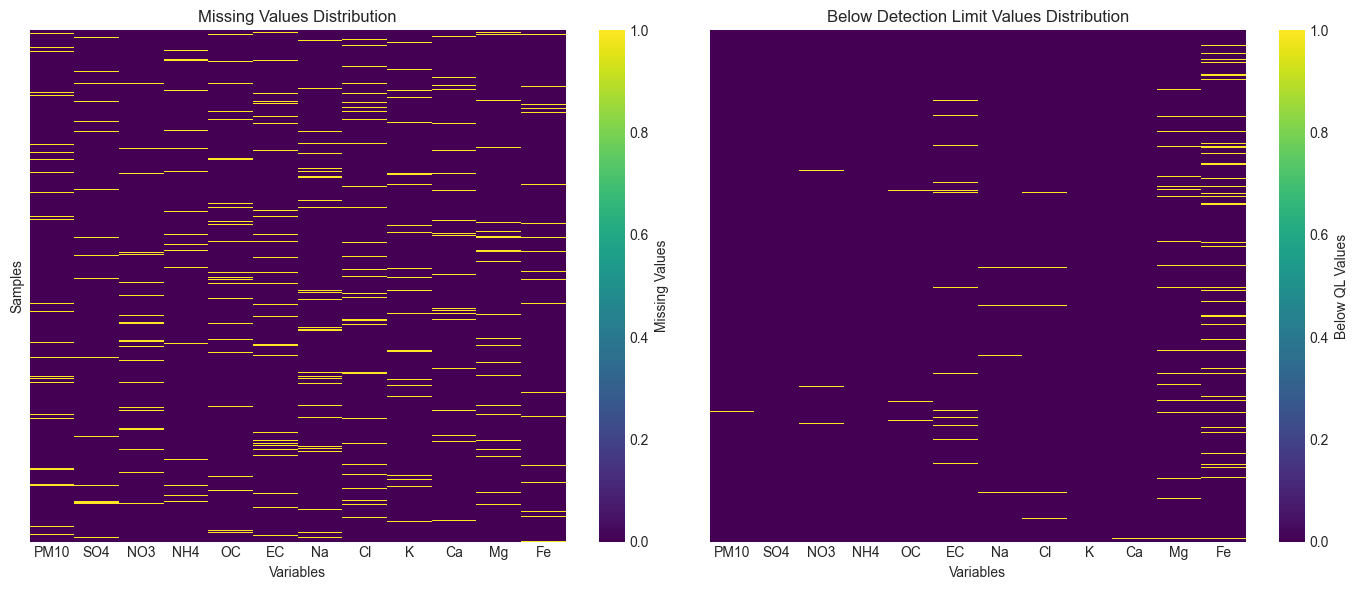

In [5]:
# Visualize missing and below detection limit values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(data.isna(), cmap='viridis', cbar_kws={'label': 'Missing Values'}, yticklabels=False)
plt.title('Missing Values Distribution')
plt.xlabel('Variables')
plt.ylabel('Samples')

plt.subplot(1, 2, 2)
sns.heatmap(dl_mask, cmap='viridis', cbar_kws={'label': 'Below QL Values'}, yticklabels=False)
plt.title('Below Detection Limit Values Distribution')
plt.xlabel('Variables')

plt.tight_layout()
plt.show()

## 2. Data Preprocessing

Now we'll go through the complete preprocessing workflow for PMF analysis:

### 2.1 Convert to Numeric Values

First, we need to convert all values to numeric, replacing below detection limit markers with appropriate numeric values (typically DL/2).

In [6]:
# Convert data to numeric with proper handling of detection limits
data_numeric = preprocessor.convert_to_numeric()

# Display the first few rows to confirm conversion
data_numeric.head()

,PM10,SO4,NO3,NH4,OC,EC,Na,Cl,K,Ca,Mg,Fe
2020-01-01,69.967142,2.021627,7.790977,1.483097,9.183505,3.009950,0.956860,1.258455,2.315710,0.262077,0.059805,0.094389
2020-01-02,63.614394,3.408994,7.149035,2.547358,9.504222,2.856291,0.593991,0.416258,2.386773,0.713628,0.209851,0.068432
2020-01-03,71.465033,1.300379,7.417699,1.542662,8.766505,NaN,1.393559,2.335390,2.548034,0.873512,NaN,0.625942
2020-01-04,80.203635,4.035822,8.584579,3.140606,9.427093,2.940471,1.623580,2.021191,2.404626,0.719014,0.092953,0.550142
2020-01-05,NaN,3.484446,9.662795,2.987467,12.152089,5.194398,1.598625,2.267092,2.620097,0.336965,0.022993,0.326297


### 2.2 Handle Missing Values (optional)

Next, we need to handle missing values using various methods:

In [7]:
# Compare different missing value handling methods
methods = {
    'interpolate': preprocessor.handle_missing_values(method='interpolate', data=data_numeric),
    'mean': preprocessor.handle_missing_values(method='mean', data=data_numeric),
    'median': preprocessor.handle_missing_values(method='median', data=data_numeric),
    'min_fraction': preprocessor.handle_missing_values(method='min_fraction', data=data_numeric, fraction=0.5)
}

# Check if missing values were filled
for method_name, data_filled in methods.items():
    print(f"{method_name}: {data_filled.isna().sum().sum()} missing values remaining")

interpolate: 0 missing values remaining
mean: 0 missing values remaining
median: 0 missing values remaining
min_fraction: 0 missing values remaining


No missing values in PM10 for demonstration, please adjust the example


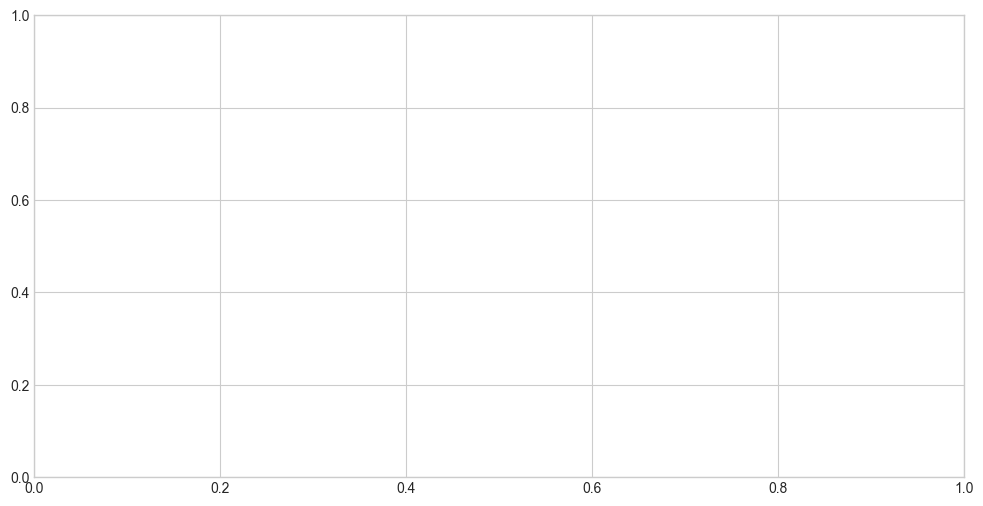

In [8]:
# Let's use interpolation for our analysis
data_filled = methods['interpolate']

# Plot an example to see how different methods filled missing values
fig, ax = plt.subplots(figsize=(12, 6))

# Select a time slice with missing values
missing_mask = data_numeric['PM10'].isna()
if missing_mask.sum() > 0:
    start_idx = missing_mask.idxmax() - pd.Timedelta(days=10)
    end_idx = missing_mask.idxmax() + pd.Timedelta(days=10)
    
    # Plot raw data with missing values
    ax.plot(data_numeric.loc[start_idx:end_idx, 'PM10'], 'o-', label='Raw Data', alpha=0.7)
    
    # Plot different filling methods
    for method_name, data_method in methods.items():
        ax.plot(data_method.loc[start_idx:end_idx, 'PM10'], 'o-', label=f'Filled ({method_name})')
    
    ax.set_title('Comparison of Missing Value Treatment Methods')
    ax.set_ylabel('PM10 Concentration (µg m$^{-3}$')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in PM10 for demonstration, please adjust the example")

### 2.3 Calculate Uncertainties

Now we'll compute uncertainties using different methods available in the PMFPreprocessor:

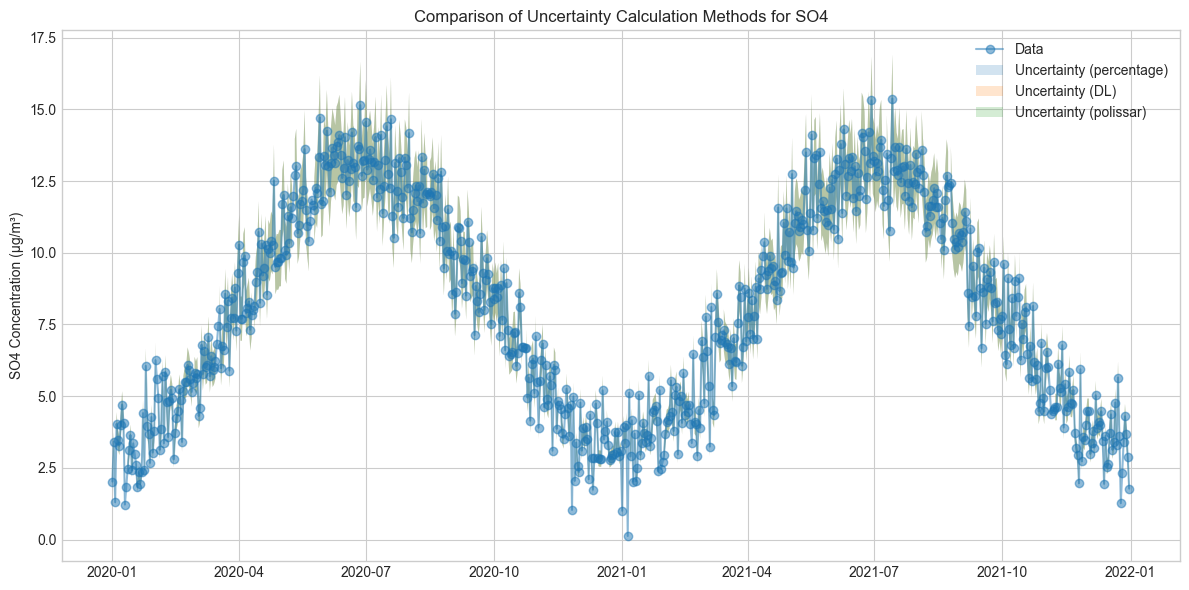

In [9]:
# Calculate uncertainties using different methods
uncertainty_methods = {
    'percentage': preprocessor.compute_uncertainties(
        method='percentage', 
        params={'percentage': 0.1}
    ),
    'DL': preprocessor.compute_uncertainties(
        method='DL', 
        params={'DL': detection_limits}
    ),
    'polissar': preprocessor.compute_uncertainties(
        method='polissar', 
        params={
            'DL': detection_limits,
            'error_fraction': 0.1
        }
    )
}

# Compare uncertainty calculation methods for a specific species
species_to_check = 'SO4'
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the original data
ax.plot(data_filled[species_to_check], 'o-', alpha=0.5, label='Data')

# Plot uncertainties as shaded regions
for method_name, uncertainties in uncertainty_methods.items():
    ax.fill_between(
        data_filled.index,
        data_filled[species_to_check] - uncertainties[species_to_check],
        data_filled[species_to_check] + uncertainties[species_to_check],
        alpha=0.2,
        label=f'Uncertainty ({method_name})'
    )

ax.set_title(f'Comparison of Uncertainty Calculation Methods for {species_to_check}')
ax.set_ylabel(f'{species_to_check} Concentration (µg/m³)')
ax.legend()
plt.tight_layout()
plt.show()

Let's use the Polissar method for our uncertainties, as it's commonly used in PMF studies:

In [10]:
# Select the uncertainties to use
uncertainties = uncertainty_methods['polissar']

# Display the uncertainty summary
uncertainty_summary = uncertainties.describe().T
uncertainty_summary['relative_uncertainty'] = uncertainty_summary['mean'] / data_filled.mean()
display(uncertainty_summary[['mean', 'std', 'min', 'max', 'relative_uncertainty']])

,mean,std,min,max,relative_uncertainty
PM10,4.489946,1.710445,0.608275,8.646360,0.100527
SO4,0.816082,0.365204,0.035505,1.538130,0.100625
NO3,0.503402,0.229974,0.035421,1.002985,0.100198
NH4,0.345641,0.086841,0.126921,0.564094,0.100372
OC,0.745910,0.233101,0.200316,1.427029,0.103164
EC,0.229054,0.090526,0.069980,0.545594,0.107887
Na,0.135129,0.048855,0.036643,0.311928,0.104498
Cl,0.198451,0.078931,0.036220,0.470471,0.102156
K,0.150314,0.071888,0.019850,0.294523,0.100614
Ca,0.081602,0.030361,0.017464,0.186617,0.103155


In [11]:
preprocessor.prepare_pmf_input()

(            PM10       SO4       NO3       NH4        OC        EC        Na  \
 2020-01-01   1.0  0.028894  0.111352  0.021197  0.131255  0.043019  0.013676   
 2020-01-02   1.0  0.053588  0.112381  0.040044  0.149404  0.044900  0.009337   
 2020-01-03   1.0  0.018196  0.103795  0.021586  0.122668       NaN  0.019500   
 2020-01-04   1.0  0.050320  0.107035  0.039158  0.117539  0.036663  0.020243   
 2020-01-05   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 ...          ...       ...       ...       ...       ...       ...       ...   
 2021-12-27   1.0  0.052090  0.116119  0.048798  0.150636  0.047084  0.019019   
 2021-12-28   1.0  0.062768  0.125415       NaN  0.147544  0.037444  0.008283   
 2021-12-29   1.0  0.061690  0.107401  0.046238  0.165941  0.052107  0.020343   
 2021-12-30   1.0  0.050028  0.147896  0.042886  0.128438  0.031099  0.027080   
 2021-12-31   1.0  0.026519  0.149709  0.037418  0.138873  0.037435  0.031911   
 
                   Cl     

### 2.4 Calculate Signal-to-Noise Ratio

Signal-to-noise ratio is important for deciding which species to include in the PMF analysis:

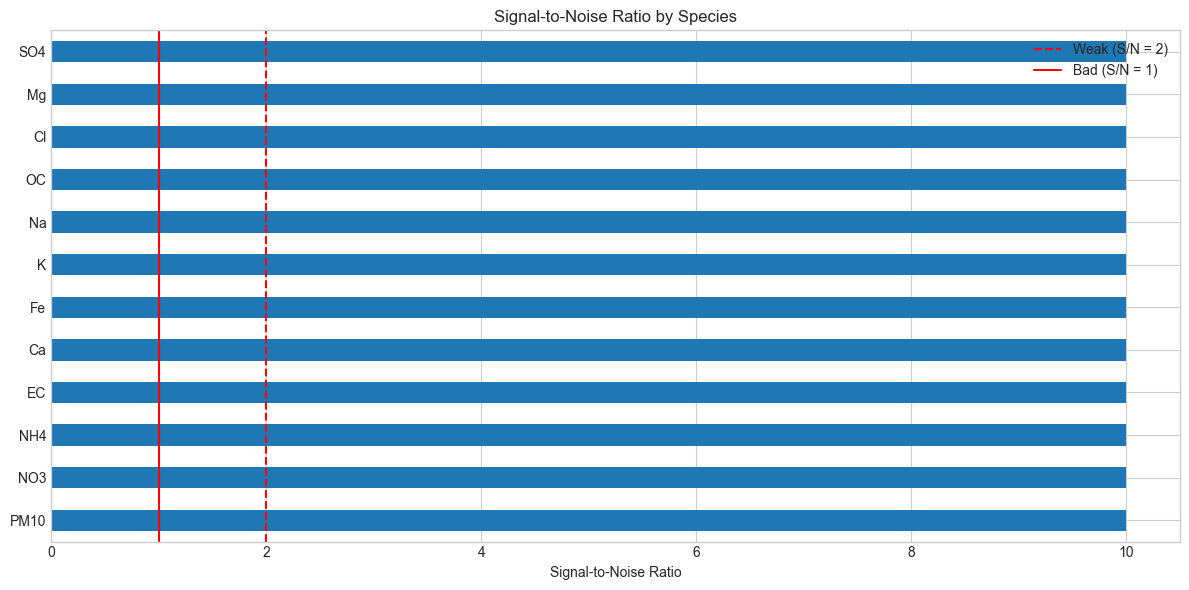

In [12]:
# Calculate signal-to-noise ratio
sn_ratio = preprocessor.compute_signal_to_noise()

# Check if we have valid S/N ratios before plotting
if len(sn_ratio) > 0 and sn_ratio.sum() > 0:
    # Plot signal-to-noise ratio for all species
    plt.figure(figsize=(12, 6))
    sn_ratio.sort_values().plot(kind='barh')
    plt.axvline(x=2, color='r', linestyle='--', label='Weak (S/N = 2)')
    plt.axvline(x=1, color='r', linestyle='-', label='Bad (S/N = 1)')
    plt.title('Signal-to-Noise Ratio by Species')
    plt.xlabel('Signal-to-Noise Ratio')
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("No valid signal-to-noise ratios were calculated.")
    print("Using a simplified calculation for demonstration purposes:")
    
    # Create a simplified S/N calculation for demonstration
    data_numeric = preprocessor.convert_to_numeric()
    simple_sn = data_numeric.std() / data_numeric.std().min()
    
    plt.figure(figsize=(12, 6))
    simple_sn.sort_values().plot(kind='barh')
    plt.axvline(x=2, color='r', linestyle='--', label='Weak (S/N = 2)')
    plt.axvline(x=1, color='r', linestyle='-', label='Bad (S/N = 1)')
    plt.title('Simplified Signal Variability Ratio by Species (Demo)')
    plt.xlabel('Signal Variability Ratio')
    plt.tight_layout()
    plt.legend()
    plt.show()

### 2.5 Compute Correlation Matrix

Let's examine correlations between species:

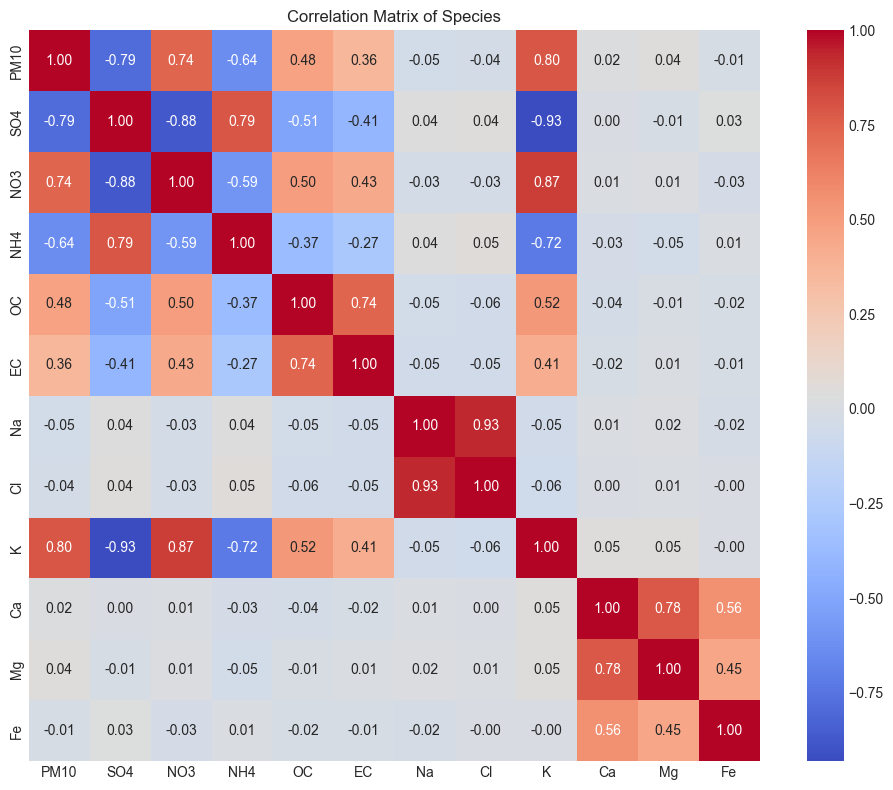

In [13]:
# Compute correlation matrix
correlation_matrix = preprocessor.compute_correlation_matrix()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Species')
plt.tight_layout()
plt.show()

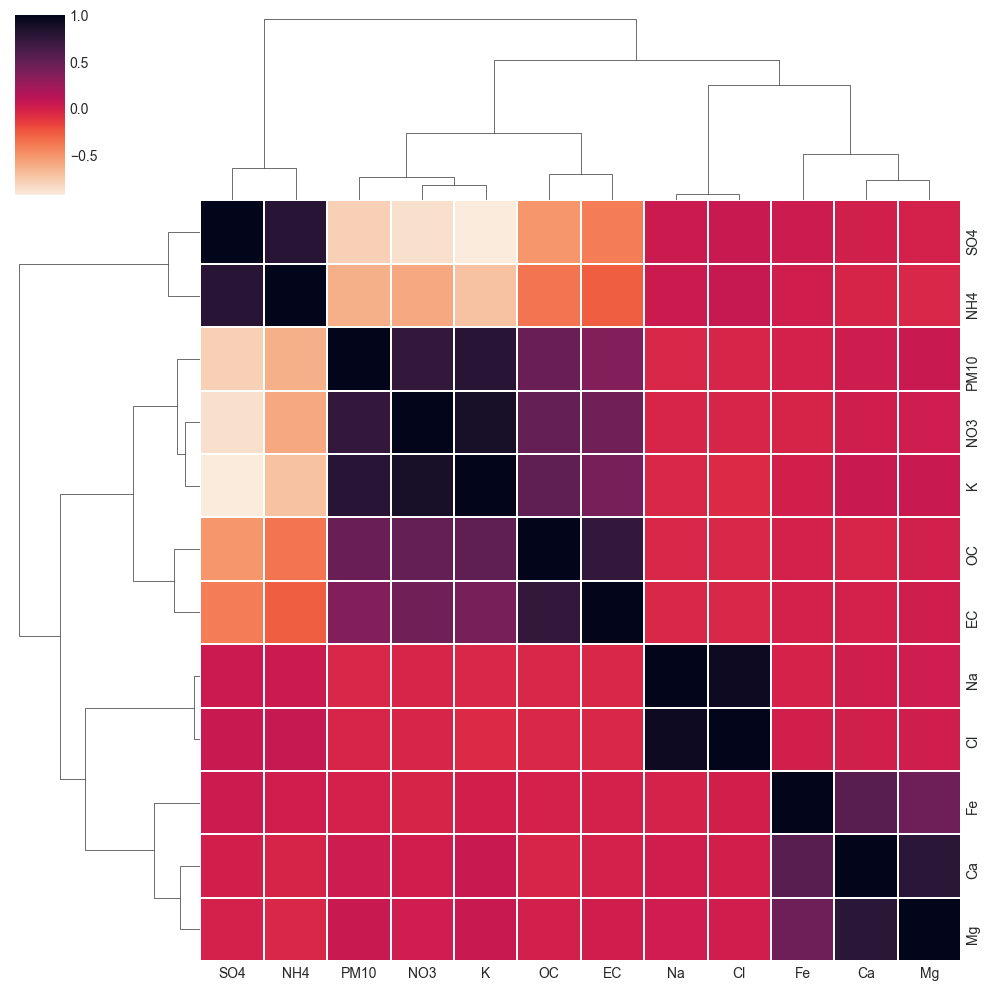

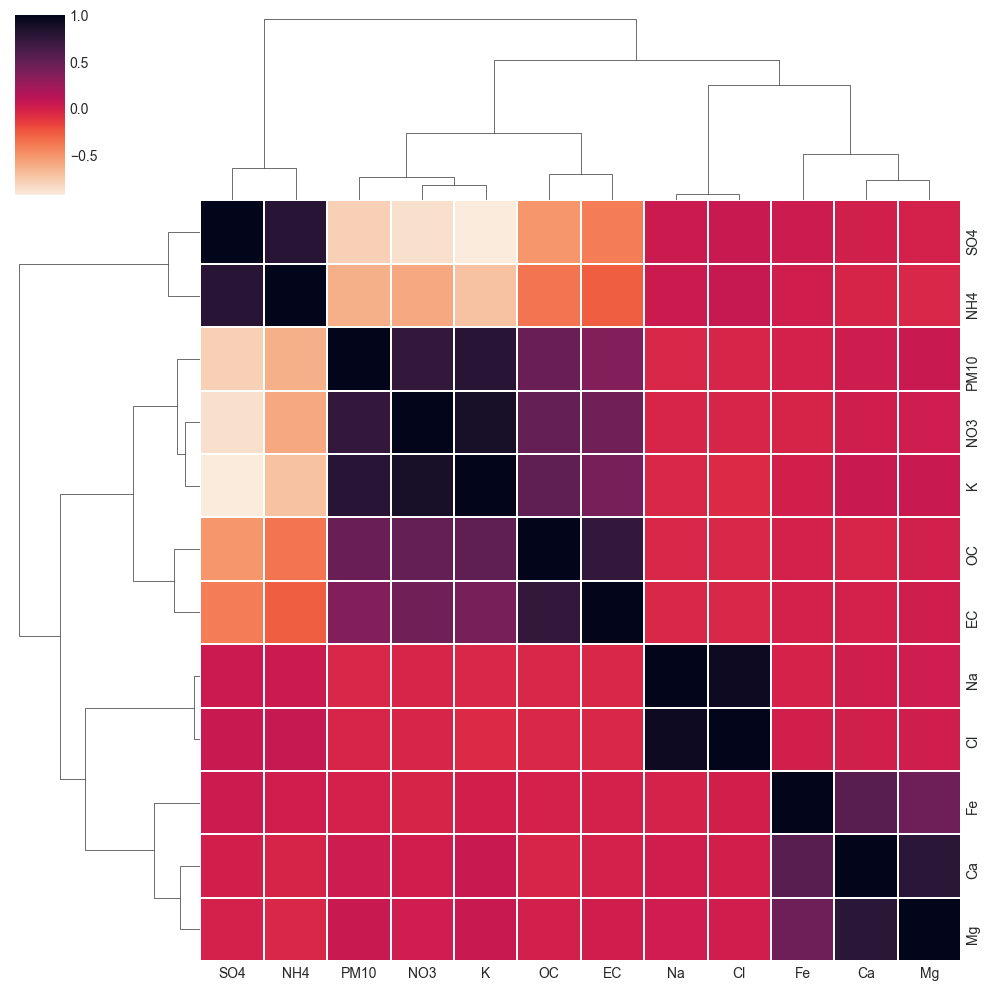

In [14]:
preprocessor.plot_heatmap(cluster = True)


### 2.6 Select Good Tracer Species

Let's identify good tracer species based on correlation and signal-to-noise:

In [15]:
# Select good tracer species
tracers = preprocessor.select_tracers(correlation_threshold=0.3, sn_threshold=3.0)
print(f"Good tracer species: {tracers}")

Good tracer species: ['PM10', 'SO4', 'NO3', 'NH4', 'OC', 'EC', 'Na', 'Cl', 'K', 'Ca', 'Mg', 'Fe']


### 2.7 Prepare Data for PMF

Now we'll filter the species based on data quality and prepare the final dataset for PMF analysis:

In [16]:
# Filter species based on data quality
data_filtered = preprocessor.filter_species(min_valid=0.75)
print(f"Species retained after filtering: {data_filtered.columns.tolist()}")

# Prepare PMF input in one step
data_normalized, uncertainties_final, metadata = preprocessor.prepare_pmf_input(
    total_var='PM10',
    uncertainty_method='polissar',
    uncertainty_params={'DL': detection_limits, 'error_fraction': 0.1},
    min_valid=0.75,
    handling_method='interpolate'
)

print("\nMetadata from PMF preparation:")
for key, value in metadata.items():
    if key != 'uncertainty_params':
        print(f"  {key}: {value}")
        
# Display the normalized data
print("\nNormalized data (first 5 rows):")
display(data_normalized.head())

Species retained after filtering: ['PM10', 'SO4', 'NO3', 'NH4', 'OC', 'EC', 'Na', 'Cl', 'K', 'Ca', 'Mg', 'Fe']

Metadata from PMF preparation:
  total_var: PM10
  uncertainty_method: polissar
  min_valid: 0.75
  handling_method: interpolate

Normalized data (first 5 rows):


,PM10,SO4,NO3,NH4,OC,EC,Na,Cl,K,Ca,Mg,Fe
2020-01-01,1.0,0.028894,0.111352,0.021197,0.131255,0.043019,0.013676,0.017986,0.033097,0.003746,0.000855,0.001349
2020-01-02,1.0,0.053588,0.112381,0.040044,0.149404,0.044900,0.009337,0.006543,0.037519,0.011218,0.003299,0.001076
2020-01-03,1.0,0.018196,0.103795,0.021586,0.122668,NaN,0.019500,0.032679,0.035654,0.012223,NaN,0.008759
2020-01-04,1.0,0.050320,0.107035,0.039158,0.117539,0.036663,0.020243,0.025201,0.029982,0.008965,0.001159,0.006859
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Exploratory Data Analysis

Let's explore our preprocessed data with the visualization tools from PMF_toolkits:

### 3.1 Time Series Analysis

Let's examine time series patterns using the preprocessing plotting functions:

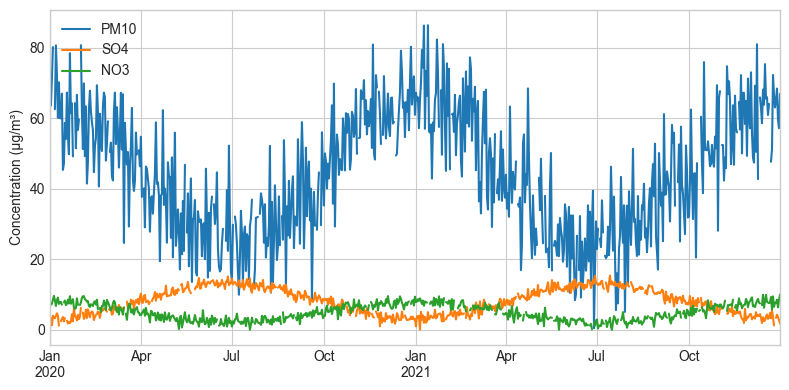

In [17]:
# Plot time series for selected species
fig = preprocessor.plot_timeseries(['PM10', 'SO4', 'NO3'], unit='µg/m³')
plt.tight_layout()
plt.show()

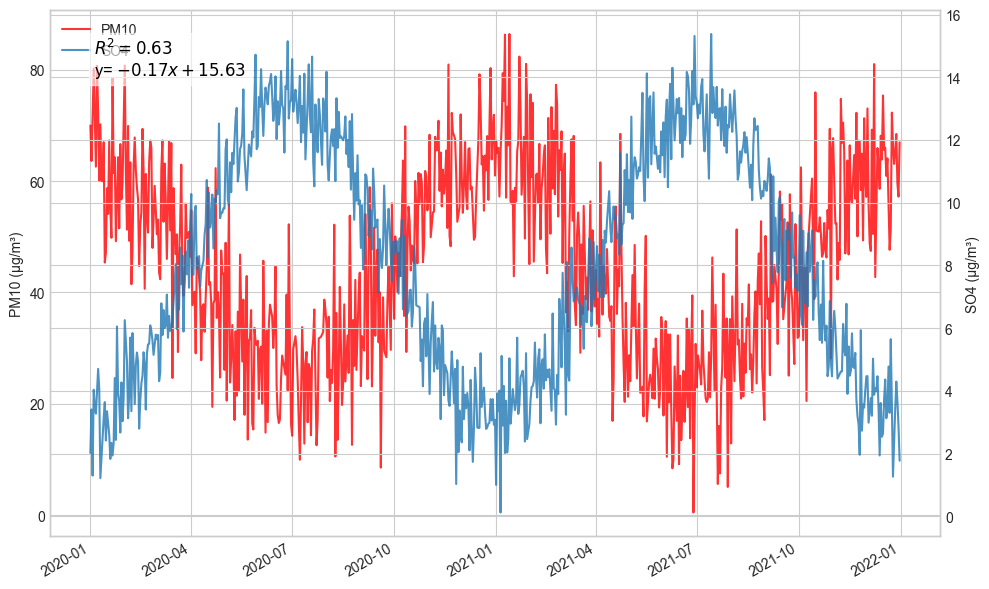

In [18]:
# Plot time series with two y-axes to compare different scales
fig = preprocessor.plot_timeseries_2axis('PM10', 'SO4', unit='µg/m³', show_equation=True)
plt.tight_layout()
plt.show()

### 3.2 Regression Analysis

Let's look at relationships between species using regression plots:

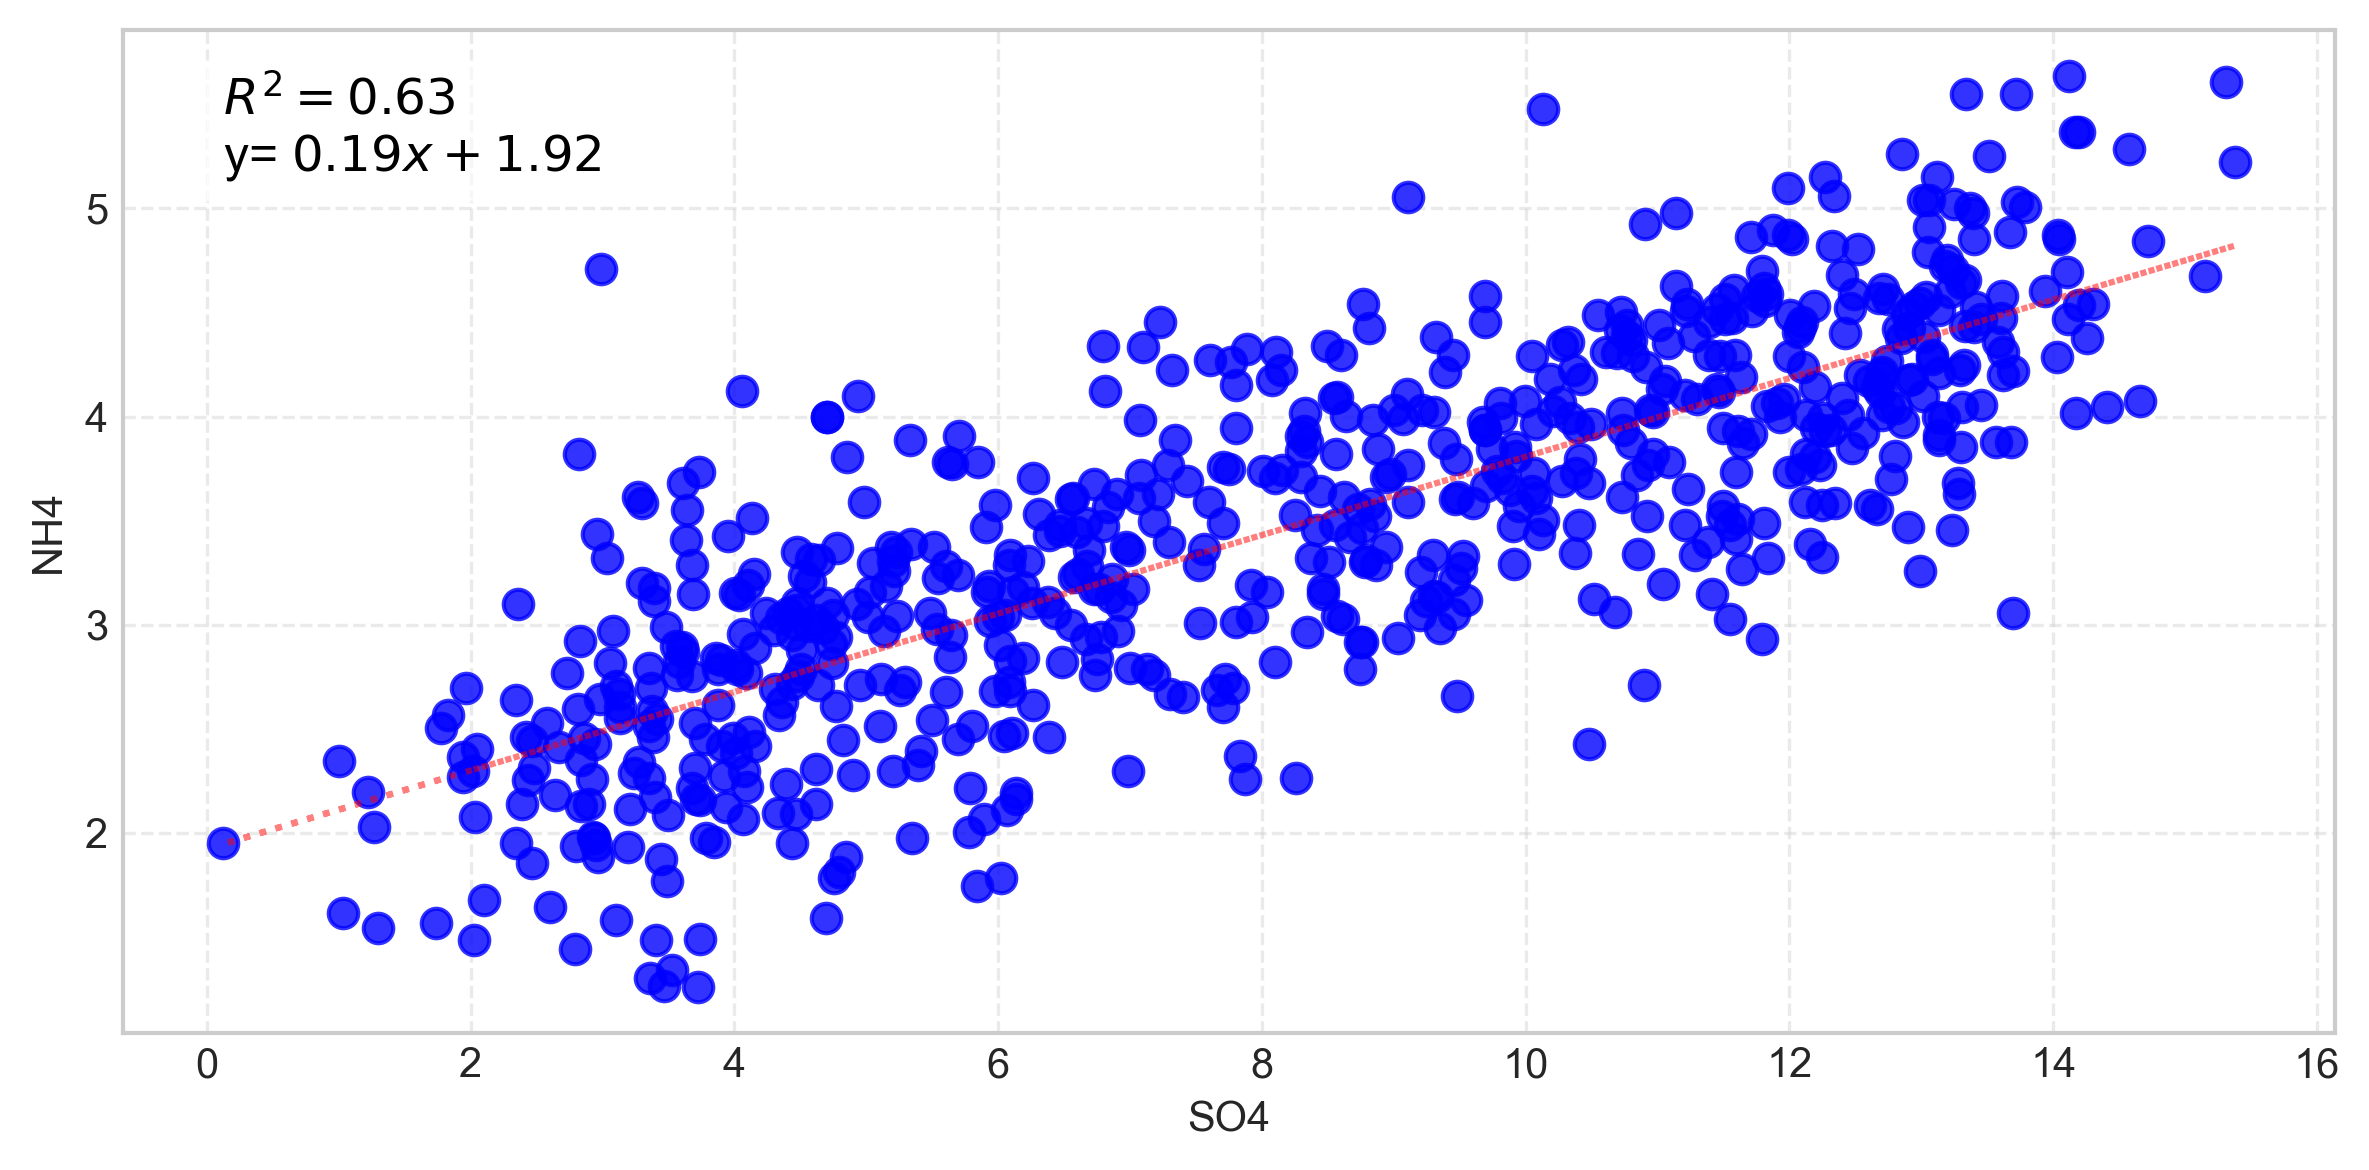

In [19]:
# Create regression plots between related species
fig = preprocessor.regression_plot('SO4', 'NH4')
plt.tight_layout()
plt.show()

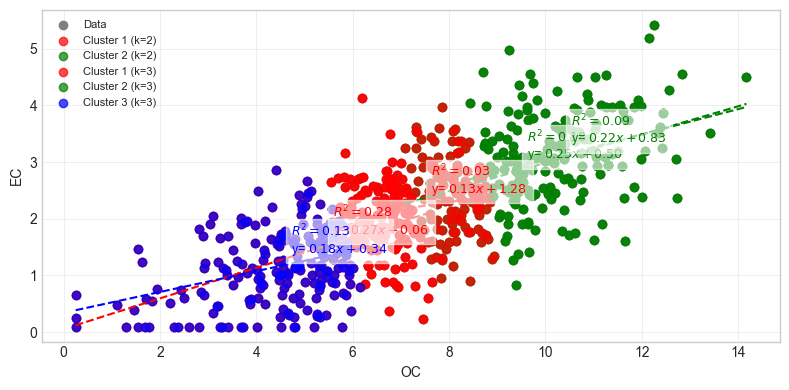


Results for k=2 clusters:
Cluster 1: 344 points, R2 = 0.278, slope = 0.270
Cluster 2: 312 points, R2 = 0.182, slope = 0.249

Results for k=3 clusters:
Cluster 1: 268 points, R2 = 0.026, slope = 0.126
Cluster 2: 181 points, R2 = 0.089, slope = 0.222
Cluster 3: 207 points, R2 = 0.126, slope = 0.184


In [20]:
# Try cluster analysis to identify different regimes
fig, results = preprocessor.cluster_analysis('OC', 'EC', n_clusters=[2, 3])
plt.tight_layout()
plt.show()

# Display cluster statistics
for k, cluster_data in results.items():
    print(f"\nResults for k={k} clusters:")
    for cluster, stats in cluster_data['cluster_stats'].items():
        print(f"Cluster {cluster+1}: {stats['count']} points, R2 = {stats['r_squared']:.3f}, slope = {stats['slope']:.3f}")

### 3.3 Seasonal Analysis

Now let's use the PMF_toolkits utility functions to analyze seasonal patterns:

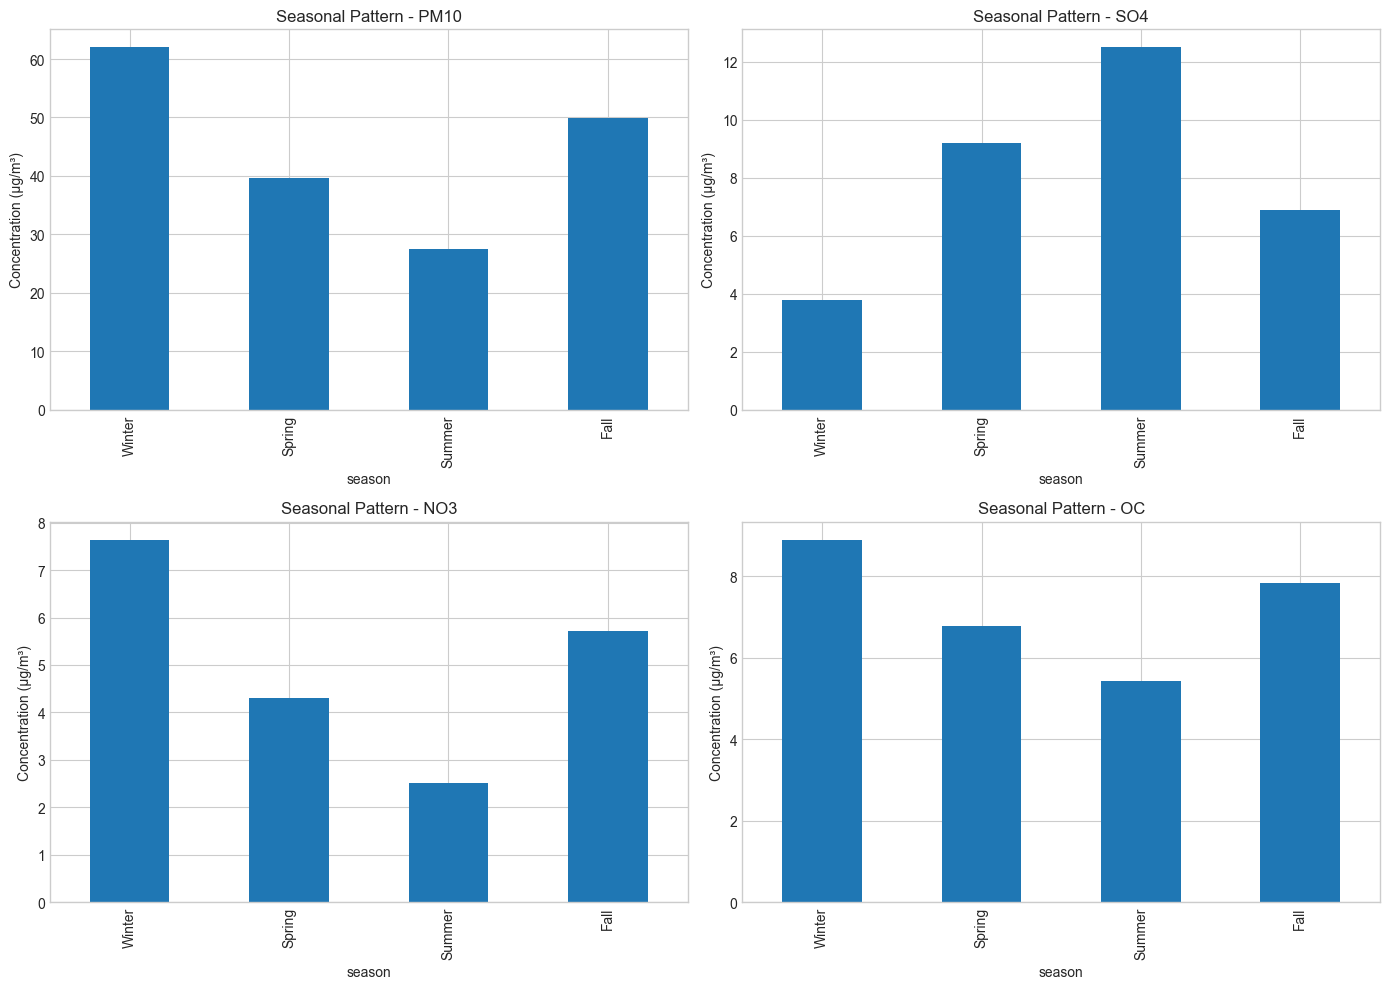

In [21]:
# Add season information to the data
seasonal_data = add_season(data_filled)

# Calculate seasonal averages
seasonal_averages = seasonal_data.groupby('season').mean()

# Reorder seasons
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_averages = seasonal_averages.reindex(season_order)

# Plot seasonal patterns for key species
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

species_to_plot = ['PM10', 'SO4', 'NO3', 'OC']
for i, species in enumerate(species_to_plot):
    seasonal_averages[species].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Seasonal Pattern - {species}')
    axes[i].set_ylabel('Concentration (µg/m³)')
    
plt.tight_layout()
plt.show()